<a href="https://colab.research.google.com/github/timrifts/GEOV261_WellTiePrac/blob/main/GEOV261_Penobscot_SyntheticWellTie_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GEOV261 Penobscot Synthetic Well Tie**

> March 2022 - GEOV261 Basin Analysis and Subsurface Interpretation - Tim Cullen and Björn Nyberg

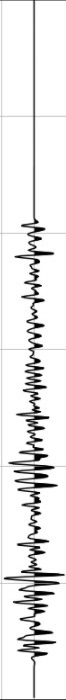


Earlier in this practical we have attempted to place well data in the context of seismic using the L-30 Penobscot Well to the seismic using checkshot data. Concerns about a number of horizons which don't obey the regional understanding have meant you need generate a well tie using a synthetic seismogram to see if there are alternative models for the time depth relationship before getting underway with interpretation of the seismic.

This notebook will guide you through the process, with some decision making required, to generate a **synthetic well tie for the L-30 well**. Where you can see a direction to change, or input a variable, do it and then either pres **"Shift + Enter**" or click the small '**play**' button that appears above each cell to run the cell, and the associated code which is hidden in the background. **Only change the code where you are directed to!**

This notebook runs through the same processes any interpretation software (such as Petrel, Kingdom or Landmark) would run to do this, but allows you to intuiatvely play with these parameters. 

The code for this notebook has been publically made available thanks to **Matt Hall of Agile Geoscience**. It uses open-source Python libraries NumPy and Matplotlib, along with a script for reading .LAS files (http://wiki.scipy.org/Cookbook/LASReader). As with all of this practical, the data is publically available from the Nova Scotia Department of Energy and Canada Offshore Petroleum Board. You can find all this and further details about this tutorial at the links below:

[AgileGeoscience Github](https://github.com/agile-geoscience)

[SEG Well Tie Calclus](https://library.seg.org/doi/10.1190/tle33060674.1)

[Penobscot Data](https://terranubis.com/datainfo/Penobscot)

Here's what Matt had to say on Synthetic seismograms...

"*Synthetic seismograms can be created by doing basic calculus on travel-time functions. Integrating slowness (the reciprocal of velocity) can a yield a time-to-depth relationship for making a well tie. Differentiating an acoustic impedance (velocity times density) log yields a reflectivity function along the borehole, which can be convolved with a seismic wavelet. In effect, the integral tells us where a given interval of rock is in the time-domain, the derivative tells us what it should look like; its seismic character.*"

In [ ]:
#@title Grab the data....
!git clone https://github.com/BjornNyberg/tutorials-2014.git

Cloning into 'tutorials-2014'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 237 (delta 42), reused 47 (delta 19), pack-reused 162
Receiving objects: 100% (237/237), 22.37 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (74/74), done.


#**Getting set up and cleaning data**

---



Make sure you are in the correct directory, or <code>cd</code> to the correct one. Then let's check the files. 

In [ ]:
%cd tutorials-2014/1406_Make_a_synthetic
%ls

/content/tutorials-2014/1406_Make_a_synthetic
Figure_1.png                 how_to_make_syntheticv2.ipynb  PenobXL_1155.txt
How_to_make_a_synthetic.pdf  L-30.las*                      README.md*
how_to_make_synthetic.ipynb  las.py                         tops.txt


Python will need to import some libraries to do what we need. 

The code below will, Import NumPy, matplotlib and pandas and the LASReader module from las.py. The las.py can be downloaded from the SciPy Cookbook (URL above), but we also give it here in the same directory. We create a well object called <code>L30</code> by passing the 'L-30.las' file into the <code>LASReader</code> module.

In [ ]:
#@title Install LASReader
!pip install las

  Created wheel for las: filename=las-0.0.3-py3-none-any.whl size=7951 sha256=dbbff5c551114b59e448b9abc45bb1a660f1051666b760155053d9c21492fe57
  Stored in directory: /root/.cache/pip/wheels/3d/a2/7e/b0d63da064da08a3a8fb49e8d60eace67abbd73234f12c4423
Successfully built las


In [ ]:
#@title Import the python libraries we need....
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.tools as tls
import pandas as pd
import numpy as np

In [ ]:
#@title Read the L-30 .las file.
import numpy as np
from las import LASReader
L30 = LASReader('L-30.las', null_subs=np.nan)

So, we have everything now....

Let's take a look at which geophysical curves are in the file,

In [ ]:
print (L30.curves.names)

['DEPTH', 'CALD', 'CALS', 'DEPT', 'DRHO', 'DT', 'GRD', 'GRS', 'ILD', 'ILM', 'LL8', 'NPHILS', 'NPHISS', 'RHOB', 'SP']


The .las file which holds the data, also holds information on the units. Let's take a look at the measured depth units for this log.

In [ ]:
print (L30.curves.DEPTH.units)

FT


The units for this log are in feet. The code will need to convert from feet to metres alot, so it easier to write a function to do this. **Make sure you run the cell below so code later on can run.**

In [ ]:
#@title Set up a feet to metres conversion!
def f2m(item_in_feet):
    "converts feet to meters"
    try:
        return item_in_feet / 3.28084
    
    except TypeError:
        return float(item_in_feet) / 3.28084
    
    return converted

For the curves that we will be accessing in the code, let's given them some shorter names. Also, some of the curves need to be converted into SI units,

In [ ]:
z = f2m(L30.data['DEPTH'])      # convert feet to metres
GR = L30.data['GRS']
IL8 = L30.data['LL8']
ILM = L30.data['ILM']
ILD = L30.data['ILD']
NPHISS = L30.data['NPHISS']
NPHILS = L30.data['NPHILS']
ILD = L30.data['ILD']
DT = L30.data['DT']*3.28084     # convert usec/ft to usec/m
RHOB = L30.data['RHOB']*1000    # convert to SI units

##**Dealing with the shallow section and the sea...**

---



Look at the well display you have been provied with. 

You will notice that the geophysical wireline logs do not run the entire length of the well, and also don't run through the water column we could see on the seismic line. To build a time-depth relationship using the well data, we need to assign a velocity for this part of the stratigraphy.

To deal with the shallow section, we first need to adjust the depths relative to sea level by subtracting the KB elevation (30.2 m) from the measured depths.

If we now integrate the sonic log, we see that time t = 0 corresponds to a depth of 347 m TVDss. To position the top of the log at the correct travel time on the seismic section, we need to use the thickness, and replacement velocities for both the water column, and the section above the log.

**Choose a replacement velocity for water. This can vary from 1400-1500 m/s** 

**Choose a velocity for section above log. Tertiary sandstones are typically 2000-2500 m/s. Perhaps this is reasonable?.....**

In the code below, look for the following variables

water_vel

and

repl_vel

Populate these with some initial values of your choice. 

In [ ]:
#@title Water Velocity (m/s)
water_vel =  1480#@param {type:"number"}


In [ ]:
#@title Shallow Replacement Velocity (m/s)
repl_vel =  1600#@param {type:"number"}


In [ ]:
#@title Summarise the well information...
KB_elev = f2m(L30.well.KB.data)  # Kelly Bushing elevation(ft)
water_depth = f2m(L30.well.GL.data) # Depth to Sea Floor below sea level (ft)
top_of_log = f2m(L30.start)   # top of log (ft) relative to KB (actually 1150 ft)

print ("KB elevation [m]: ", f2m(L30.well.KB.data)) # Kelly Bushing (ft)
print ("Seafloor elevation [m]: ", f2m(L30.well.GL.data)) # Depth to sea floor below sea level (ft)

repl_int = f2m(L30.start) - f2m(L30.well.KB.data) + f2m(L30.well.GL.data)
water_vel = water_vel  # velocity of sea water [m/s]

EGL_time = 2.0 * np.abs(f2m(L30.well.KB.data)) / water_vel
print ("Ground Level time above SRD :", EGL_time)

water_twt = 2.0*abs(water_depth + EGL_time) / water_vel
print ("water_time: ", water_twt)

print ("Top of sonic log [m]: ", f2m(L30.start))  # top of log (ft) (actually 1150 ft)
print ("replacement interval [m]: ", repl_int)

repl_vel = repl_vel # m/s
repl_time = 2.0 * repl_int / repl_vel
print ("two-way-replacement time: ", repl_time)

log_start_time = water_twt + repl_time 
print ('log_start_time:', log_start_time)

def tvdss(md):
    "assumes a vertical well"
    return md - f2m(L30.well.KB.data)

top_log_TVDss = f2m(L30.well.KB.data) - f2m(L30.well.GL.data) 

KB elevation [m]:  30.175199034393632
Seafloor elevation [m]:  -137.46479560112655
Ground Level time above SRD : 0.04077729599242383
water_time:  0.18570813284477586
Top of sonic log [m]:  347.47198888089633
replacement interval [m]:  179.83199424537614
two-way-replacement time:  0.22478999280672018
log_start_time: 0.410498125651496


##**Fixing / editing the logs**

---



At the beginning of the practical, we discussed how the impedance of a rock can be determined from acoustic properties and density. 

These are recording in the sonic log, and density log along the logged section of the well, but is at quite a high resolution compared to the scale we're working at, and also contains a number of extreme and/or spurious data points.  We therefore need to clip the spikes from the data, and smooth this out. 

Note: it is not enoough to just clip the very extremes of the data, as there is a general increase in these properties down the borehole (i.e it has a trend!). So we will use a rolling average instead to smooth it out instead.

Now we can smooth with a rolling median filter (preserves edges, only attacks spikes). Note we are not actually going to use the smoothed version, but we are going to use the difference to decide where the spikes are. Play with the size of the window using the slider below to examine the effect of different rolling averages. 

Note: the window number corresponds to depth sampling points, which in this well occur every 0.1524m. So 13 corresponds to ~ 2 metres.  

In [ ]:
#@title Choose a rolling average window....

def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        return rolled

window = 13 #@param {type:"slider", min:5, max:50, step:1}


In [ ]:
#@title Plot the data!

rho_sm = np.median(rolling_window(RHOB,window), -1)
rho_sm = np.pad(rho_sm, window//2, mode='edge')

fig = go.Figure()
fig.add_trace(go.Scatter(x=z, y=RHOB,
                    mode='lines',
                    name='orig'))
fig.add_trace(go.Scatter(x=z, y=rho_sm,
                    mode='lines',
                    name='smooth'))
fig.show()

That's the data smoothed, but it's still quite spiky!

Now we will find spikes by comparing the original data with the median-smoothed data. If they differ by more than 100 (arbitrary), then it's a spike. (Alternately, we could use the DRHO (Density Correction) curve as a threshold for this):

In [ ]:
##Define a function for despiking
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

##Now that the indicies of the spiky data are known, you can replace with clipped version of the same spike. 

rho = despike(RHOB, rho_sm, max_clip = 100)

Let's examine a segment of the log to see what effect it had,

In [ ]:
#@title Look at the despiking and smoothing effect....
fig = go.Figure()
fig.add_trace(go.Scatter(x=z, y=RHOB,
                    mode='lines',
                    name='orig'))
fig.add_trace(go.Scatter(x=z, y=rho_sm,
                    mode='lines',
                    name='smooth'))
fig.add_trace(go.Scatter(x=z, y=rho,
                    mode='lines',
                    name='despiked'))
fig.show()


Do the same thing for the sonic log,

In [ ]:
#@title Despike the sonic...
##Despike the sonic

dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, window//2, mode='edge')
dt = despike(DT, dt_sm, max_clip = 10)

##Plot the figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=z, y=DT,
                    mode='lines',
                    name='orig'))
fig.add_trace(go.Scatter(x=z, y=dt_sm,
                    mode='lines',
                    name='smooth'))
fig.add_trace(go.Scatter(x=z, y=dt,
                    mode='lines',
                    name='despiked'))
fig.show()


#**Computing the time-to-depth relationship**

---



The time-to-depth relationship is obtained by scaling the sonic log by the sample interval (6" or 0.1524 m) and essentially summing up all the individual DT values (or "integrating"). (Python does this by calling <code>np.cumsum()</code> on it.)

In [ ]:
# two-way-time to depth relationship
scaled_dt = 0.1524 * np.nan_to_num(dt) / 1e6

tcum = 2 * np.cumsum(scaled_dt)
tdr = tcum + log_start_time

###Compute acoustic impedance

Remember from the lecture that acoustic impedance (Z) is the product of velocity and density. Complete the code in the cell below to define a variable for acoustic impedance.

The variable name for sonic is `dt` and for density is `rho`

Z = pV.

Don't rush though... remember the units of the sonic log. The sonic log records **slowness** in microseconds/ft (i.e the time taken for the sonic pulse to travel one foot through the formation, known as delta T - hence the log curve is called dT!). A conversion equation between velocity and slowness is:

V = 1 million/ dt. Quite convienent!

In [ ]:
Z = 

###Compute reflection coefficient series

Now we know the impedance of a rock, we can compare compedences side by side to understand the reflection coefficient. Run the cell below to define a reflection coefficient variable `RC` which calculates the derivative of the Impedance. We'll use this later...

In [ ]:
RC = (Z[1:] - Z[:-1]) / (Z[1:] + Z[:-1])

# **Viewing the time-depth relationship in the context of other well data**

---



###**Get well tops**

In the files that we grabbed at the start, there was a file called "Well Tops.txt". Lets look at those. 

In [ ]:
#@title View Well Tops
# Get well tops for plot annotation
tops = {}

with open('tops.txt') as f:
    for line in f.readlines():
        if not line.startswith('#'):
            temp = line.strip().split('\t')
            tops[temp[-1].replace('_',' ')] = float(temp[1])
            
tops

{'Abenaki': 3404.311,
 'Base O-Marker': 2469.207,
 'Dawson Canyon': 984.504,
 'L Baccaro': 3964.534,
 'L Missisauga': 3190.646,
 'Logan Canyon': 1136.904,
 'Mid Baccaro': 3485.083,
 'U Missisauga': 2251.253,
 'Wyandot': 867.156}

Now there is a time-depth relationship established from the previous part. We can lookup those depths of the well top horizons against that to get the corresponding time.

In [ ]:
#@title View Well Tops in TWT...
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

tops_twt = {}

for key, val in tops.items():
    tops_twt[key] = tdr[find_nearest(z, val)]
    
tops_twt

{'Abenaki': 2.4675975744107514,
 'Base O-Marker': 1.9860390619888015,
 'Dawson Canyon': 1.010202759647407,
 'L Baccaro': 2.715656617052546,
 'L Missisauga': 2.3644401111056275,
 'Logan Canyon': 1.1354146356548704,
 'Mid Baccaro': 2.50139841149472,
 'U Missisauga': 1.8729713893709286,
 'Wyandot': 0.9227200900456212}

**Fill in these values, rounded to 3 decimal places in to your table on your worksheet. How do these compare to the values you determined from the time-depth relationship dervied from the checkshot data?**

###**View the well tops and well log data.**

Plot the logs in the depth domain using the code below.

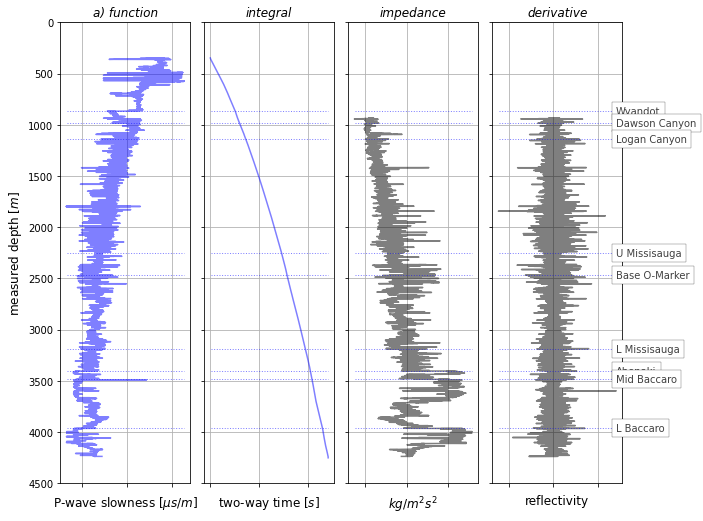

In [ ]:
#@title Plot!
f1 = plt.figure(figsize = (10,8))

ax1 = f1.add_axes([0.1, 0.1, 0.18, 0.8])
ax1.plot( DT, z,'b', alpha=0.5)
ax1.set_title('a) function', style = 'italic')
ax1.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel('P-wave slowness '+ r'$[\mu s/m]$', fontsize = '12')
ax1.set_ylim(0, 4500)
ax1.set_xticklabels('')
ax1.invert_yaxis()
ax1.grid()

ax2 = f1.add_axes([0.3 , 0.1, 0.18, 0.8])
ax2.plot(tcum, z, 'b', alpha = 0.5)
ax2.set_title('integral', style = 'italic')
ax2.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
ax2.invert_yaxis()
ax2.set_yticklabels('')
ax2.set_xticklabels('')
ax2.set_ylim(4500, 0)
ax2.grid()

ax3 = f1.add_axes([0.5, 0.1, 0.18, 0.8])
ax3.plot( Z, z, 'k', alpha=0.5)
ax3.set_title('impedance', style = 'italic')
ax3.set_xlabel(r'$kg/m^2s^2$', fontsize = '12')
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticklabels('')
ax3.set_ylim(4500, 0)
ax3.grid()

ax4 = f1.add_axes([0.7, 0.1, 0.18, 0.8])
ax4.plot( RC, z[:-1], 'k', alpha=0.5)
ax4.set_title('derivative', style = 'italic')
ax4.set_xlabel('reflectivity', fontsize = '12')
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticklabels('')
ax4.set_ylim(4500, 0)
ax4.grid()

for i in range (4):
    for top in tops.values() :
        f1.axes[i].axhline( y = float(top), color = 'b', lw = 1, 
                            ls = ':',  
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )

for top, depth in tops.items():
    ax4.text( x = max(ax4.xaxis.get_data_interval())*1.0,
              y = float(depth), s = top,
                         alpha=0.75, color='k',
                         fontsize = '10',
                         horizontalalignment = 'left',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
                         weight = 'light')

ax5 = f1.add_axes([0.8, 0.1, 0.18, 0.8])
ax5.invert_yaxis()
ax5.set_ylim(4500, 0)
ax5.set_axis_off()

In the above plot you can see


*   The original sonic data
*   The integral of the smoothed and despiked sonic data (the time-depth relationship)
*   The impedance (note this increases as the rock gets increasingly compacted and harder)
*   The derivative of that impedance, giving us the "reflectivity". 





###**How would this look as a seismic response?**

Aside from a higher 'resolution' time-depth relationship, having calculated the impedance down a well means we can approximate the seismic response of stratigraphy to further check if the seismic character of a horizon in the well matches the seismic, and identify which horizons or parts of the stratigraphy may be causing particular reflectors. 

**For this, we need to view our data in the time domain. Run the cell below to resample the data in to the time domain.**

In [ ]:
#@title RUN ME!
# RESAMPLING FUNCTION
dt = 0.004
maxt = 3.0

t = np.arange(0, maxt, dt) 

Z_t = np.interp(x = t, xp = tdr, fp = Z)

RC_t = (Z_t[1:] - Z_t[:-1]) / (Z_t[1:] + Z_t[:-1])

##Creating the synthetic

The final step in generating a synthetic seismogram down the well, is generating a seismic wavelet, which can be convolved with our reflection coefficient calculated earlier to produce a synthetic seismic trace. 

In this example we will use a simple ricker-wavelet, which is a good first-order approximation of the single air-gun explosion used in the acquisiation of the seismic. 



In [ ]:
#@title Generate a Ricker Wavelet function.
# Define a wavelet.
def ricker(f, length, dt):
    t = np.linspace(-length / 2, (length-dt) / 2, int(length / dt))
    y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

Use the cell below to generate a ricker wavelet. **Change the frequency and length parameters to examine the impact on the wavelet..**

The code works in the format below, if you manage to loose the code you can use this to write it back in correctly.

```
# tw, w = ricker (f=frequency, length = duration, dt = sample interval) 
```


We'll choose a frequency of 25 Hz, with a duration of 0.512s and sample interval of 0.004s for our synthetic which we'll generate in the next cell.


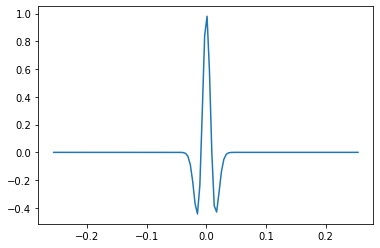

In [ ]:
tw, w = ricker (f=25, length = 0.512, dt = 0.004)
plt.plot(tw, w)

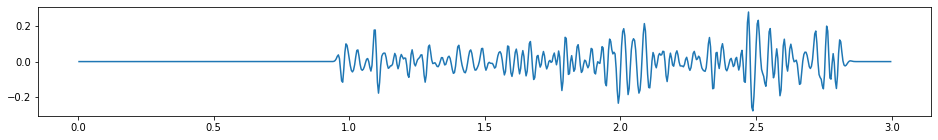

In [ ]:
#@title Run this cell to convolve the wavelet with the reflection coefficient and generate a wiggle! 
RC_t = np.nan_to_num(RC_t)
#tw, w = ricker (f=25, length = 0.512, dt = 0.004)
synth = np.convolve(w, RC_t, mode='same')

plt.figure(figsize=(16,2))
plt.plot(t[1:], synth)

###Viewing a final product

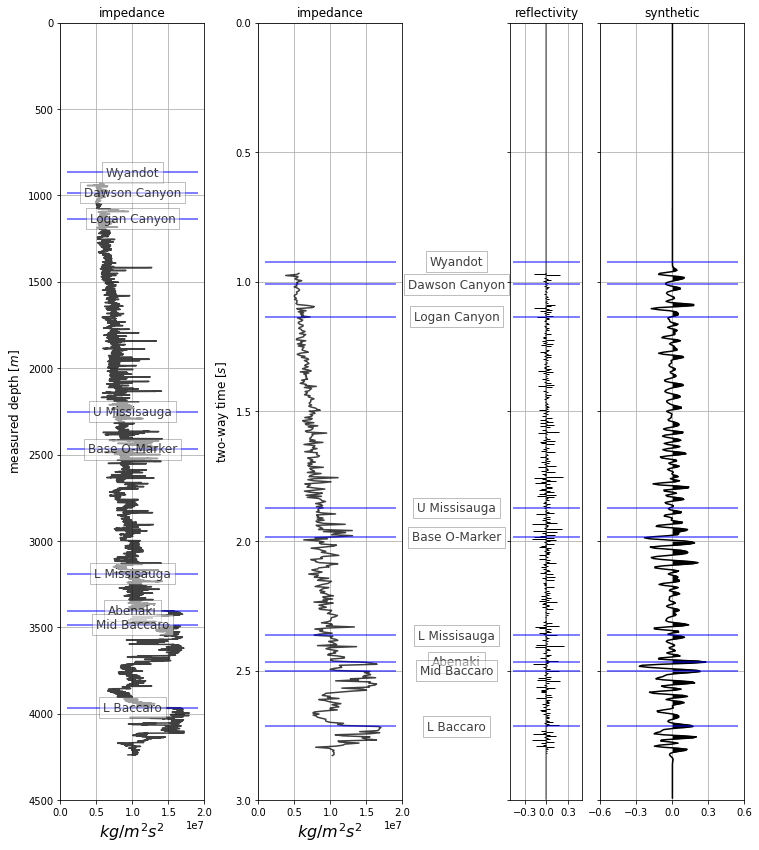

In [ ]:
#@title Plot the synthetic with the well data
f2 = plt.figure(figsize=[10,12])

ax1 = f2.add_axes([0.05, 0.1, 0.2, 0.9])
ax1.plot(Z, z,'k', alpha=0.75)
ax1.set_title('impedance')
ax1.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
ax1.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax1.set_ylim(0, 4500)
ax1.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax1.invert_yaxis()
ax1.grid()

ax2 = f2.add_axes([0.325, 0.1, 0.2, 0.9])
ax2.plot(Z_t, t,'k', alpha=0.75)
ax2.set_title('impedance')
ax2.set_ylabel('two-way time ' + '$[s]$', fontsize = '12' )
ax2.set_xlabel(r'$kg/m^2s^2$ ', fontsize = '16')
ax2.set_ylim(0, 3)
ax2.set_xticks( [0.0e7, 0.5e7, 1.0e7, 1.5e7, 2.0e7 ] )
ax2.invert_yaxis()
ax2.grid()

ax3 = f2.add_axes([0.675, 0.1, 0.1, 0.9])
ax3.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
ax3.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
ax3.set_title('reflectivity')
ax3.set_xlabel('', fontsize = '10')
ax3.set_ylim(0, 3)
ax3.set_xlim(-0.5, 0.5)
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_xticks([-0.3, 0, 0.3] )
ax3.grid()

ax4 = f2.add_axes([0.8, 0.1, 0.2, 0.9])
ax4.plot(synth, t[:-1],'k')
ax4.fill_betweenx(t[:-1], synth,  0,  synth > 0.0,  color='k', alpha = 1.0)
ax4.set_title('synthetic')
ax4.set_xlabel('', fontsize = '10')
ax4.set_ylim(0, 3)
ax4.set_xlim(-0.05, 0.05)
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_xticks([-0.6, -0.3, 0, 0.3, 0.6 ] )
ax4.grid()

for i in range(1):
    for top, depth in tops.items():
        f2.axes[i].axhline( y = float(depth), color = 'b', lw = 2, 
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )
        f2.axes[i].text( x = 1e7, y = float(depth)-0.015, s = top,
                         alpha=0.75, color='k',
                         fontsize = '12',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                         weight = 'light')
        

for i in range(1,4):
    for twt in tops_twt.values():
        f2.axes[i].axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
for i in range(1,2):
    for top, twt in tops_twt.items():
        f2.axes[i].text( x = 2.75e7, y = float(twt), s = top,
                         alpha=0.75, color='k',
                         fontsize = '12',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                         weight = 'light'
                         )

##Comparison with real data and seismic...

real data is located at trace 77 of 500

In [ ]:
#@title Load the seismic line
traces = np.loadtxt('PenobXL_1155.txt')

# rearrange traces for plotting
traces = np.fliplr(np.transpose(traces))

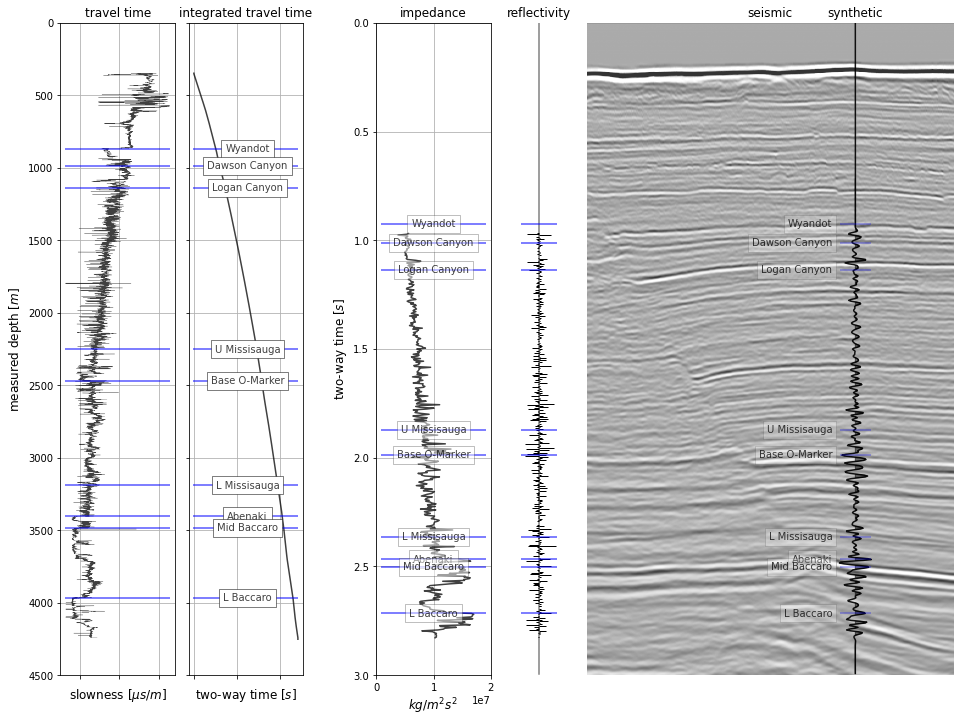

In [ ]:
#@title Plot
import matplotlib.gridspec as gridspec

f3 = plt.figure(figsize=[16,12])

gs = gridspec.GridSpec(1, 6, width_ratios = [1.25, 1.25, 0.5, 1.25, 0.75, 4])

# depth domain

axa = plt.subplot(gs[0])
axa.plot( DT, z,'k', alpha=0.75, lw=0.25)
axa.set_title('travel time')
axa.set_ylabel('measured depth ' + '$[m]$', fontsize = '12' )
axa.set_xlabel('slowness 'r'$[\mu s/m]$', fontsize = '12')
axa.set_ylim(0, 4500)
axa.set_xticklabels('')
axa.invert_yaxis()
axa.grid()
gs.update(wspace=0.1)

axb = plt.subplot(gs[1])
axb.plot(tcum, z, 'k', alpha = 0.75)
axb.set_title('integrated travel time')
axb.set_xlabel('two-way time ' + '$[s]$', fontsize = '12')
axb.invert_yaxis()
axb.set_yticklabels('')
axb.set_xticklabels('')
axb.set_ylim(4500, 0)
axb.grid()

for top, depth in tops.items():
    axa.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.axhline( y = float(depth), color = 'b', lw = 2, 
                         alpha = 0.5, xmin = 0.05, xmax = 0.95 )
    axb.text( x = 1.25, y = float(depth)-0.015, s = top,
                         alpha=0.75, color='k',
                         fontsize = '10',
                         horizontalalignment = 'center',
                         verticalalignment = 'center',
                         bbox=dict(facecolor='white', alpha=1.0, lw = 0.5),
                         weight = 'light')

# time domain

#white space between depth and time plots
axoff = plt.subplot(gs[2])
axoff.set_axis_off()

axc = plt.subplot(gs[3])
axc.plot( Z_t, t, 'k', alpha=0.75)
axc.set_title('impedance')
axc.set_ylabel('two-way time '+ '$[s]$', fontsize = '12' )
axc.set_xlabel(r'$kg / m^2s^2$ ', fontsize = '12')
axc.set_ylim(0, 3)
axc.set_xlim(0, 2e7)
axc.invert_yaxis()
axc.grid()

for top, twt in tops_twt.items():
    axc.axhline( y = float(twt), color = 'b', lw = 2, 
                    alpha = 0.5, xmin = 0.05, xmax = 0.95)
    axc.text(x = 1e7, y = float(twt), s = top,
                        alpha=0.75, color='k',
                        fontsize = '10',
                        horizontalalignment = 'center',                             
                        verticalalignment = 'center',
                        bbox=dict(facecolor='white', alpha=0.5, lw = 0.5),
                        weight = 'light')     

axd = plt.subplot(gs[4])
axd.hlines(t[:-1], 0, RC_t, color='k', lw = 1)                    # Stems
axd.plot([0, 0], [t.min(), t.max()], '-', c='k', alpha = 0.5)     # Middle bar
axd.set_title('reflectivity')
axd.set_xlabel('', fontsize = '12')
axd.set_ylim(0, 3)
axd.set_xlim(-0.5, 0.5)
axd.invert_yaxis()
axd.set_yticklabels('')
axd.set_axis_off()
axd.grid()
for depth in tops_twt.values():
    axd.axhline(y = float(depth), color = 'b', lw = 2, 
                alpha = 0.5, xmin = 0.25, xmax = 0.75)

axe = plt.subplot(gs[5])
axe.imshow( traces[:750,100:], cmap = 'Greys', 
           vmin = -7000, vmax = 7000, alpha = 0.8,
           aspect = 'auto'
           )
axe.set_axis_off()
axe.set_title('seismic')

# put synthetic on seismic
bottom = axe.get_position().get_points()[0][1]
top =  axe.get_position().get_points()[1][1]

axf = axe.figure.add_axes([0.79, bottom, 0.05, top-bottom])
gain_synth = 1
axf.plot(gain_synth * synth, t[:-1], 'k', alpha = 0.9)
axf.fill_betweenx(t[:-1], gain_synth * synth,  0, 
                  gain_synth * synth > 0.0,
                  color = 'k', alpha = 0.5)
axf.set_title('synthetic')
axf.set_xlabel('', fontsize = '12')
axf.set_ylim(0, 3)
axf.set_xlim(-0.5 ,0.5)
axf.invert_yaxis()
axf.set_yticklabels('')
axf.set_axis_off()
axf.grid()
for top, twt in tops_twt.items():
    axf.axhline( y = float(twt), color = 'b', lw = 2, 
                alpha = 0.25, xmin = 0.25, xmax = 0.75)
    axf.text(x = -0.4, y = float(twt), s = top,
             alpha=0.75, color='k',
             fontsize = '10',
             horizontalalignment = 'right',
             verticalalignment = 'center',
             bbox=dict(facecolor='white', alpha=0.25, lw = 0.5),
             weight = 'light')

#f3.savefig('Figure_1.png', facecolor = 'white', dpi = 300)

So there it is! A synthetic seismogram. 


Consider the following, which we will discuss in the class.

1.   How do your results and chosen horizons from the synthetic compare to those from the original checkshot data?
2.   Does the synthetic look like it is reproducing the seismic data faitfully? Where does it differ? Why might this be?
3. How might we identify any remaining mis-ties? and how might we deal with them?

